In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score

temp_dir = "temp_download"
# Load selected features
X_train = pd.read_csv(os.path.join(temp_dir,"X_train_selected.csv"))
X_val = pd.read_csv(os.path.join(temp_dir,"X_val_selected.csv"))
X_test = pd.read_csv(os.path.join(temp_dir,"X_test_selected.csv"))

y_train_res = pd.read_csv(os.path.join(temp_dir, "y_train_res.csv")).values.ravel()
y_train = pd.read_csv(os.path.join(temp_dir, "y_train.csv")).values.ravel()
y_val = pd.read_csv(os.path.join(temp_dir, "y_val.csv")).values.ravel()
y_test = pd.read_csv(os.path.join(temp_dir, "y_test.csv")).values.ravel()

# Load raw data for comparison

X_train_raw = pd.read_csv(os.path.join(temp_dir,"X_train_scaled.csv"))
X_val_raw = pd.read_csv(os.path.join(temp_dir,"X_val_scaled.csv"))

In [2]:
import os
import time
import joblib
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from tqdm.notebook import tqdm


def compare_models_on_datasets(models_dict, dataset_dict, results_dir="temp_download"):
    """
    Train and evaluate models on multiple datasets for comparison
    
    Parameters:
    models_dict (dict): Dictionary of model names and initialized estimators
    dataset_dict (dict): Dictionary of dataset names and tuples (X_train, X_val, y_train, y_val)
    results_dir (str): Root directory to save all results
    """
    
    all_metrics = []
    
    for dataset_name, (X_train, X_val, y_train, y_val) in tqdm(dataset_dict.items(), desc="Datasets"):
        dataset_dir = os.path.join(temp_dir, dataset_name)
        os.makedirs(dataset_dir, exist_ok=True)
        
        metrics = []
        model_progress = tqdm(models_dict.items(), desc=f"Models on {dataset_name}", leave=False)
        
        for model_name, model in model_progress:
            try:
                # Train model
                start_time = time.time()
                model.fit(X_train, y_train)
                training_time = time.time() - start_time
                
                # Predict
                y_pred_proba = model.predict_proba(X_val)[:, 1]
                y_pred = (y_pred_proba >= 0.5).astype(int)
                
                # Calculate metrics
                metrics.append({
                    "Dataset": dataset_name,
                    "Model": model_name,
                    "AUC": roc_auc_score(y_val, y_pred_proba),
                    "F1": f1_score(y_val, y_pred),
                    "Training_Time": training_time,
                    "Features": X_train.shape[1]
                })
                
                # Save artifacts
                joblib.dump(model, os.path.join(dataset_dir, f"{model_name}.pkl"))
                pd.DataFrame({"true": y_val, "pred": y_pred}).to_csv(
                    os.path.join(dataset_dir, f"{model_name}_preds.csv"),
                    index=False
                )
                
            except Exception as e:
                print(f"Error with {model_name} on {dataset_name}: {str(e)}")
                continue
        
        # Save dataset-specific metrics
        dataset_metrics = pd.DataFrame(metrics)
        dataset_metrics.to_csv(os.path.join(dataset_dir, "metrics.csv"), index=False)
        all_metrics.append(dataset_metrics)
    
    # Generate comparison report
    final_report = pd.concat(all_metrics)
    final_report.to_csv(os.path.join(results_dir, "comparison_report.csv"), index=False)
    
    return final_report

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Calculate class weight ratio
fraud_ratio = sum(y_train) / len(y_train)  # From EDA
scale_pos_weight = (1 - fraud_ratio) / fraud_ratio

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        is_unbalance=True,
        random_state=42
    )
}
# Load raw and processed datasets
raw_data = (
    X_train_raw,
    X_val_raw,
    y_train,
    y_val
)

processed_data = (
    X_train,
    X_val,
    y_train,
    y_val
)

# Define datasets to compare
datasets = {
    "raw": raw_data,
    "processed": processed_data
}

# Run comparison
report = compare_models_on_datasets(models, datasets)

# Display results
print("\nModel Performance Comparison:")
print(report.pivot_table(index="Model", columns="Dataset", values=["AUC", "F1"]))

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Models on raw:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 335, number of negative: 193333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 193668, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001730 -> initscore=-6.358039
[LightGBM] [Info] Start training from score -6.358039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Models on processed:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 335, number of negative: 193333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 193668, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001730 -> initscore=-6.358039
[LightGBM] [Info] Start training from score -6.358039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

In [4]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'eval_metric': 'logloss',
        'device': 'cuda',
        'n_jobs': -1
    }

    # Create and train the model with the suggested hyperparameters
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    mean_score = scores.mean()

    return mean_score

In [5]:
# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best parameters and the best score
print("Best Parameters:", study.best_params)
print("Best ROC AUC Score:", study.best_value)

[I 2025-02-05 17:31:59,361] A new study created in memory with name: no-name-8e3530d8-21a0-42b8-b779-12cc8674068c
/home/nick/snap/code/181/.local/share/virtualenvs/fraud-detection-mlops-5wXwr5xg/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:32:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-02-05 17:32:03,646] Trial 0 finished with value: 0.9767203798599469 and parameters: {'n_estimators': 416, 'max_depth': 8, 'learning_rate': 0.1339838499599488, 'subsample': 0.6071995271403807, 'colsample_bytree': 0.9556970134155323, 'gamma': 0.000387519

Best Parameters: {'n_estimators': 452, 'max_depth': 5, 'learning_rate': 0.010184111764379264, 'subsample': 0.8456857997702265, 'colsample_bytree': 0.8891343221784842, 'gamma': 7.768655258094173e-08, 'min_child_weight': 5, 'reg_alpha': 0.00031740586974679085, 'reg_lambda': 0.1577424844120056}
Best ROC AUC Score: 0.9830092368357145


In [12]:
# Train the final model with the best parameters
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42, device='cuda', scale_pos_weight=scale_pos_weight)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [13]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.87      0.45        98

    accuracy                           1.00     56962
   macro avg       0.65      0.93      0.73     56962
weighted avg       1.00      1.00      1.00     56962



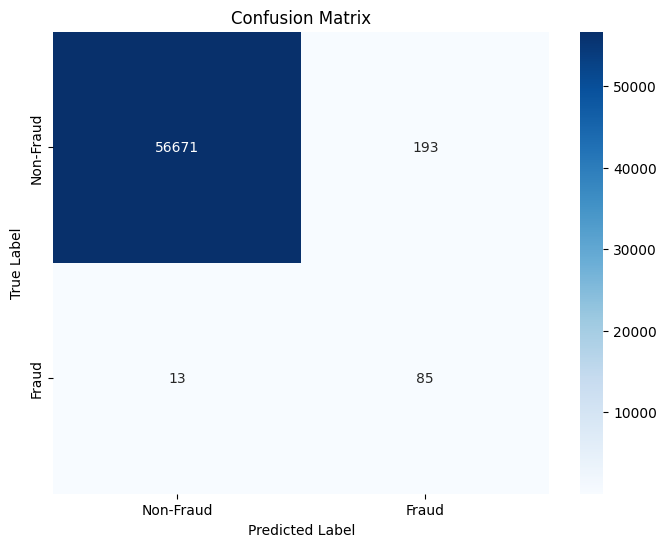

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()